<a href="https://colab.research.google.com/github/tatendatobaiwa/cnn/blob/main/cnnmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2: Create Directories in Drive

Step 3: Install Dependenices

In [5]:
!pip install -q -U tensorflow-addons
import tensorflow as tf
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Add custom directory to Python path
project_path = '/content/drive/MyDrive/cnn_project'
sys.path.append(project_path)

Fix Dependency Conflicts

In [ ]:
!pip install -q --upgrade tensorflow-addons

Verify Fixes

In [7]:
import tensorflow as tf
import tensorflow_addons as tfa

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Addons version: {tfa.__version__}")

TensorFlow version: 2.13.0
TensorFlow Addons version: 0.23.0


Step 4: Use a script to Load and Preprocess Data

In [9]:
import cv2
import numpy as np
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class DataProcessor:
    def __init__(self, base_path="/content/drive/MyDrive/cnn_project"):
        self.base_path = Path(base_path)
        self.train_path = self.base_path / "data/raw/train"
        self.test_path = self.base_path / "data/raw/test"

    def load_images(self, directory, target_size=(256, 256)):
        """
        Loads and processes images from the given directory.
        Assumes images are organized in subdirectories named 'benign', 'malignant', and 'normal'.
        """
        images = []
        labels = []
        class_names = ['benign', 'malignant', 'normal']
        for label, class_name in enumerate(class_names):
            class_dir = directory / class_name
            for img_path in class_dir.glob('*'):
                if img_path.suffix.lower() in ('.png', '.jpg', '.jpeg'):
                    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                    if img is None:
                        print(f"Warning: Unable to load image {img_path}")
                        continue
                    img = cv2.resize(img, target_size)
                    images.append(img)
                    labels.append(label)
        return np.array(images), np.array(labels)

    def create_generators(self, batch_size=32):
        """
        Loads images, splits them into training and validation sets, and creates data generators.
        """
        # Load images and normalize pixel values to [0, 1]
        X_train, y_train = self.load_images(self.train_path)
        X_train = X_train[..., np.newaxis] / 255.0

        # Split into training and validation sets with stratification to maintain class balance
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
        )

        # Define data augmentation for the training set
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # No augmentation for validation set
        val_datagen = ImageDataGenerator()

        # Create generators
        train_generator = train_datagen.flow(
            X_train, y_train, batch_size=batch_size, shuffle=True
        )
        val_generator = val_datagen.flow(
            X_val, y_val, batch_size=batch_size, shuffle=False
        )

        return train_generator, val_generator, X_val, y_val

    def show_augmented_images(self, generator, n_images=5):
        """
        Displays a sample of augmented images from the provided generator.
        """
        # Fetch a batch of images and labels
        images, labels = next(generator)
        plt.figure(figsize=(15, 3))
        for i in range(n_images):
            plt.subplot(1, n_images, i+1)
            # Use squeeze() to remove the channel dimension for grayscale images
            plt.imshow(images[i].squeeze(), cmap='gray')
            plt.title(f"Label: {labels[i]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()


Verifcation of Successful Image Loading via Visualisation.

data_processing.py  evaluate.py  __init__.py  model.py	__pycache__  xai.py


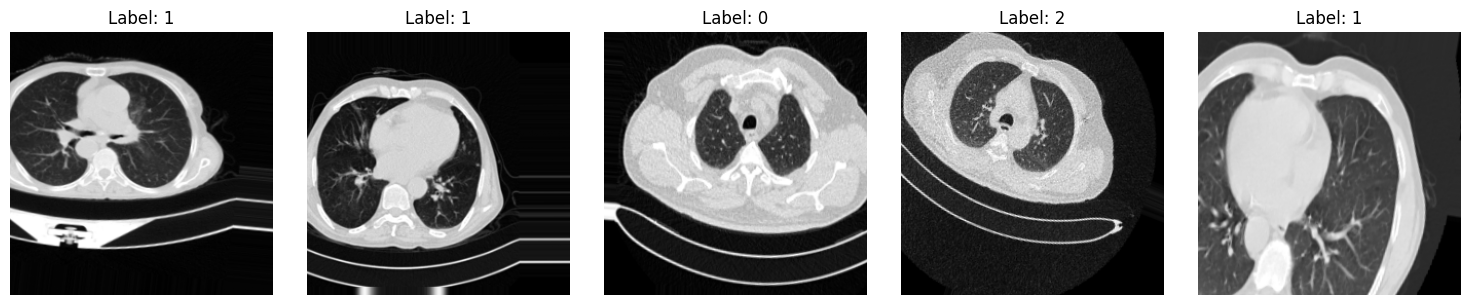

In [1]:
import sys
project_path = '/content/drive/MyDrive/cnn_project'
if project_path not in sys.path:
    sys.path.append(project_path)

# Check that the file exists in the expected directory
!ls /content/drive/MyDrive/cnn_project/utils

# Optionally reload the module if needed
import importlib
import utils.data_processing as dp
importlib.reload(dp)

# Now try importing DataProcessor
from utils.data_processing import DataProcessor

# Initialize and test the DataProcessor
processor = DataProcessor()
train_gen, val_gen, X_val, y_val = processor.create_generators(batch_size=32)
processor.show_augmented_images(train_gen, n_images=5)


Step 5: Model Development

In [2]:
import tensorflow as tf

def create_model(input_shape=(256, 256, 1)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Step 5: Model Evaluation and Optimization

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_val, y_val, class_names: list = ['benign', 'malignant', 'normal']):
    """
    Comprehensive model evaluation with visualization.

    Parameters:
      - model: Trained Keras model.
      - X_val: Validation images.
      - y_val: True labels for the validation set.
      - class_names: List of class names corresponding to the labels.
    """
    # Generate predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=class_names))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Calculate and print accuracy per class
    class_acc = {}
    for i, class_name in enumerate(class_names):
        mask = y_val == i  # boolean mask for samples of the current class
        class_acc[class_name] = np.mean(y_pred_classes[mask] == y_val[mask])

    print("\nClass-wise Accuracy:")
    for class_name, acc in class_acc.items():
        print(f"{class_name}: {acc:.2%}")

    # Optional: Calculate and print overall accuracy
    overall_acc = accuracy_score(y_val, y_pred_classes)
    print(f"\nOverall Accuracy: {overall_acc:.2%}")


Ensuring robust model training and optimization

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from utils.data_processing import DataProcessor
from utils.model import create_model
import matplotlib.pyplot as plt

def train_model(model, train_generator, val_generator, epochs=50, checkpoint_path='best_model.h5'):
    """
    Train the model using robust optimization callbacks.

    Parameters:
      model: The compiled Keras model.
      train_generator: Training data generator.
      val_generator: Validation data generator.
      epochs: Maximum number of epochs to train.
      checkpoint_path: File path to save the best model.

    Returns:
      history: Training history object.
    """
    # Callback to stop training if validation loss doesn't improve after a given number of epochs
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Callback to save the model after every epoch if the validation loss improved
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Callback to reduce learning rate if the validation loss plateaus
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Combine callbacks into a list
    callbacks = [early_stop, checkpoint, reduce_lr]

    # Train the model using the generators
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

def plot_training_history(history):
    """
    Visualize the training history (loss and accuracy).
    """
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Initialize the data processor and create data generators
    processor = DataProcessor()
    train_gen, val_gen, X_val, y_val = processor.create_generators(batch_size=32)

    # Create the model (make sure the input shape matches your data)
    model = create_model(input_shape=(256, 256, 1))

    # Train the model with optimization callbacks
    history = train_model(model, train_gen, val_gen, epochs=50, checkpoint_path='best_model.h5')

    # Visualize the training history
    plot_training_history(history)


Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 1.0873 - accuracy: 0.4755
Epoch 1: val_loss improved from inf to 0.97245, saving model to best_model.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 125s 4s/step - loss: 1.0873 - accuracy: 0.4755 - val_loss: 0.9724 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 0.9637 - accuracy: 0.5074
Epoch 2: val_loss improved from 0.97245 to 0.94383, saving model to best_model.h5
28/28 [==============================] - 119s 4s/step - loss: 0.9637 - accuracy: 0.5074 - val_loss: 0.9438 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 0.9359 - accuracy: 0.5108
Epoch 3: val_loss improved from 0.94383 to 0.93060, saving model to best_model.h5
28/28 [==============================] - 110s 4s/step - loss: 0.9359 - accuracy: 0.5108 - val_loss: 0.9306 - val_accuracy: 0.5136 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - ETA: 0s - loss: 0.9386 - accuracy: 0.4800
Epoch 4: val_loss did not improve from 0.93060
28/28 [==============================] - 105s 4s/step - loss: 0.9386 - accurac

Step 6: Explainable AI (XAI) Integration

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name: str = 'conv2d_2', class_index: int = None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Parameters:
        model (tf.keras.Model): The trained Keras model.
        img_array (np.array): Preprocessed image array of shape (1, height, width, channels).
        layer_name (str): Name of the convolutional layer to use for Grad-CAM.
        class_index (int, optional): Index of the class for which to compute the heatmap.
                                     If None, the class with the highest predicted probability is used.

    Returns:
        superimposed_img (np.array): The original image overlaid with the Grad-CAM heatmap.
    """
    # Create a model that maps the input image to the activations of the target layer and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    # Compute gradients of the loss with respect to the convolution outputs
    grads = tape.gradient(loss, conv_outputs)
    # Compute the mean intensity of the gradients over each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Get the convolution outputs for the first image in the batch
    conv_outputs = conv_outputs[0]
    # Multiply each channel in the feature map array by its corresponding gradient importance
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()

    # Apply ReLU to the heatmap (only positive contributions)
    heatmap = np.maximum(heatmap, 0)
    # Normalize the heatmap to the range [0, 1]
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    # Resize the heatmap to match the input image dimensions and convert to 8-bit
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    # Apply the JET color map to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Prepare the original image for superimposition (assumes grayscale)
    img = np.uint8(255 * img_array[0].squeeze())
    # Convert grayscale to BGR for color superimposition
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    # Superimpose the heatmap onto the original image
    superimposed_img = cv2.addWeighted(img_bgr, 0.6, heatmap, 0.4, 0)

    return superimposed_img

def visualize_explanations(model, X_val, y_val, num_samples: int = 3):
    """
    Visualizes model predictions alongside Grad-CAM explanations for a random set of samples.

    Parameters:
        model (tf.keras.Model): The trained Keras model.
        X_val (np.array): Validation images.
        y_val (np.array): True labels for the validation images.
        num_samples (int): Number of samples to visualize.
    """
    class_names = ['benign', 'malignant', 'normal']
    # Randomly select indices for visualization
    indices = np.random.choice(len(X_val), num_samples, replace=False)

    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices, 1):
        img = X_val[idx]
        true_label = class_names[y_val[idx]]

        # Get model prediction
        pred = model.predict(np.expand_dims(img, axis=0))
        pred_class = class_names[np.argmax(pred)]

        # Generate Grad-CAM explanation for the image
        explanation = grad_cam(model, np.expand_dims(img, axis=0))

        # Plot the original image with true and predicted labels
        plt.subplot(num_samples, 2, 2*i - 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}\nPred: {pred_class}")
        plt.axis('off')

        # Plot the Grad-CAM explanation
        plt.subplot(num_samples, 2, 2*i)
        plt.imshow(explanation)
        plt.title("Grad-CAM Explanation")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Visualizing explanations

In [ ]:
from utils.xai import visualize_explanations
visualize_explanations(model, X_val, y_val, num_samples=3)